## Q-performance comparison

In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer, cython_pricer_optimized

In [2]:
from learning.utils.load_experiment import LoadExperiment
ldr = LoadExperiment(backup=True)

In [9]:
cps = ldr.list_checkpoints('MONOSPLINE-0', 0)
ag = ldr.load_agent_from_path(cps[40])

[INFO] [2021-03-09 23:38:32,555] [C:\Users\mmark\Documents\Projects\credit_collections_rl\learning\resources\backup\models\MONOSPLINE-0\20210203-162838\checkpoints\4000] - Instantiated class DQNAgent
[WARNING] [2021-03-09 23:38:32,861] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-03-09 23:38:32,881] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [10]:
cps[3]

'C:\\Users\\mmark\\Documents\\Projects\\credit_collections_rl\\learning\\resources\\backup\\models\\MONOSPLINE-0\\20210203-162838\\checkpoints\\300'

In [11]:
ww, ll, p, z = policy_pricer.create_map(ag, larger_offset=True)

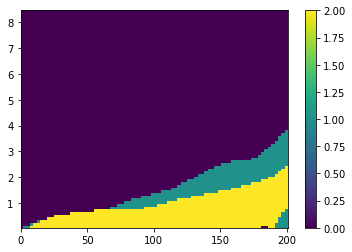

In [12]:
plt.pcolormesh(ww, ll, p, shading='auto')
plt.colorbar()

In [24]:
%%timeit
vals_pars = policy_pricer.value_account_parallel(np.array([0.2, 200]), ww, ll, p, ag.env.params, ag.env.env.action_bins, n_iterations=10000)

1.24 s ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
vals = np.asarray(cython_pricer_optimized.value_account(np.array([0.2, 200]), ww, ll, p, cython_pricer_optimized.convert_params_obj(ag.env.params), ag.env.env.action_bins, n_iterations=10000))

2.93 s ± 99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
np.mean(vals)

142.26108295080144

In [23]:
np.mean(vals_pars)

139.97369299767445

In [14]:
%%timeit
agent.main_net.predict_on_batch(converted[None, :])

1.92 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
agent.main_net(converted[None, :])

313 µs ± 6.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%%timeit
agent.main_net.predict(converted[None, :])

27.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
np.argmax(agent.main_net.predict(agent.env.observation(point)[None, :]))

2

In [145]:
import logging, sys
logging.disable(sys.maxsize)

def checkpoints_and_paths(name):
    # name = "Vanilla4ActionsSplines50K"
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(logs)
    log_num = 1
    checkpoints_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints')
    checkpoints = np.sort(np.array(os.listdir(checkpoints_path), dtype='int32'))
    checkpoints_paths = [os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints', str(pasorted)) for pasorted in checkpoints]
    return checkpoints_paths

def plot_learning_performance(names):
    checkpoint_paths = [checkpoints_and_paths(name) for name in names]
    accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
    values = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    actions = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    agentf = load_agent_from_path(checkpoints_paths[-1])
    trans_acc = agentf.env.observation(accounts)
    for i, cp in enumerate(tqdm(checkpoint_paths[0][:200])):
        for j, n in enumerate(names):
            agent = load_agent_from_path(checkpoint_paths[j][i])
            values[i, :, j] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
            actions[i, :, j] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    return values , actions

In [146]:
vals, actions = plot_learning_performance(["Vanilla4ActionsSplines50K", "Penalized4ActionsSplines50K"])


['20201215-215946', '20201215-215951']
['20201215-214758', '20201215-215926']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:35<00:00,  2.10it/s]


Text(0.5, 1.0, 'Constrained vs NonConstrained')

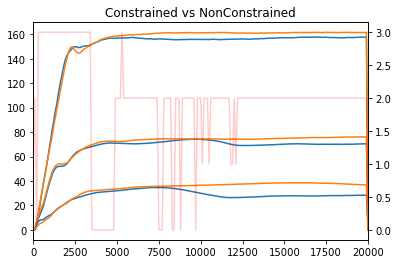

In [157]:
fig, ax = plt.subplots()
ax.plot(checkpoints, vals[:, 0, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 0, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 1, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 1, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 2, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 2, 1], color = 'C1')
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0, 0], color='red', alpha=0.2)
ax.set_xlim([0, 20000])
ax.set_title('Constrained vs NonConstrained')

In [125]:
import logging, sys
from tqdm import tqdm
logging.disable(sys.maxsize)

accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
values = np.zeros((len(checkpoints), accounts.shape[0]))
actions = np.zeros((len(checkpoints), accounts.shape[0]))
agentf = load_agent_from_path(checkpoints_paths[-1])
trans_acc = agentf.env.observation(accounts)
for i, cp in enumerate(tqdm(checkpoints)):
    agent = load_agent_from_path(checkpoints_paths[i])
    values[i, :] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    actions[i, :] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


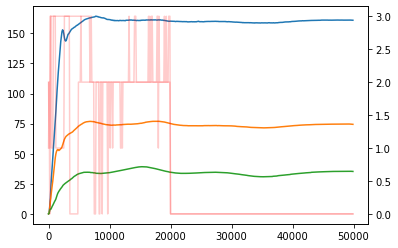

In [147]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 0])
ax.plot(checkpoints, values[:, 1])
ax.plot(checkpoints, values[:, 2])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0], color='red', alpha=0.2)

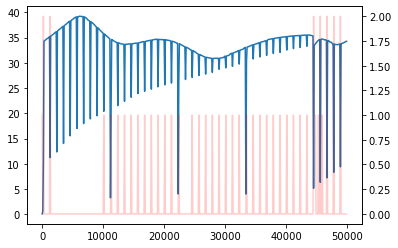

In [101]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 1])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 1], color='red', alpha=0.2)

In [ ]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

In [57]:
agent = load_agent_from_path(checkpoints_paths[2])

[INFO] [2021-02-04 12:50:13,158] [C:\Projects\credit_collections_rl\learning\resources\models\Vanilla4ActionsSplines50K\20201215-215951\checkpoints\1000] - Instantiated class DQNAgent
[WARNING] [2021-02-04 12:50:13,358] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-04 12:50:13,370] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [67]:
agent.env.observation(np.array([[1. , 100], [1. , 50]] ))

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [72]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

array([42.100174, 10.450637], dtype=float32)

In [58]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    
#     w_normalized = np.linspace(0, 1, w_points)
#     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
#     wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    space_iterator = product(l, w)
    space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
    predictions = agent.main_net.predict_on_batch(space_product)
    z = np.amax(predictions, axis=1).reshape(l_points, w_points)
    p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

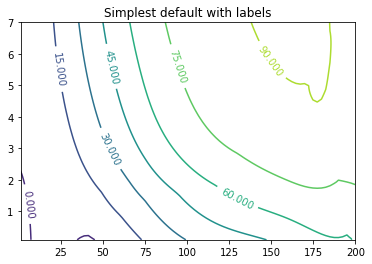

In [59]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')